<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/lifetimeCalibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import logit, expit
from scipy.optimize import fsolve

# Config
%config InlineBackend.figure_format = 'retina' #Retina display
warnings.filterwarnings('ignore') #Disable warning
plt.style.use('seaborn-deep') #Plot style

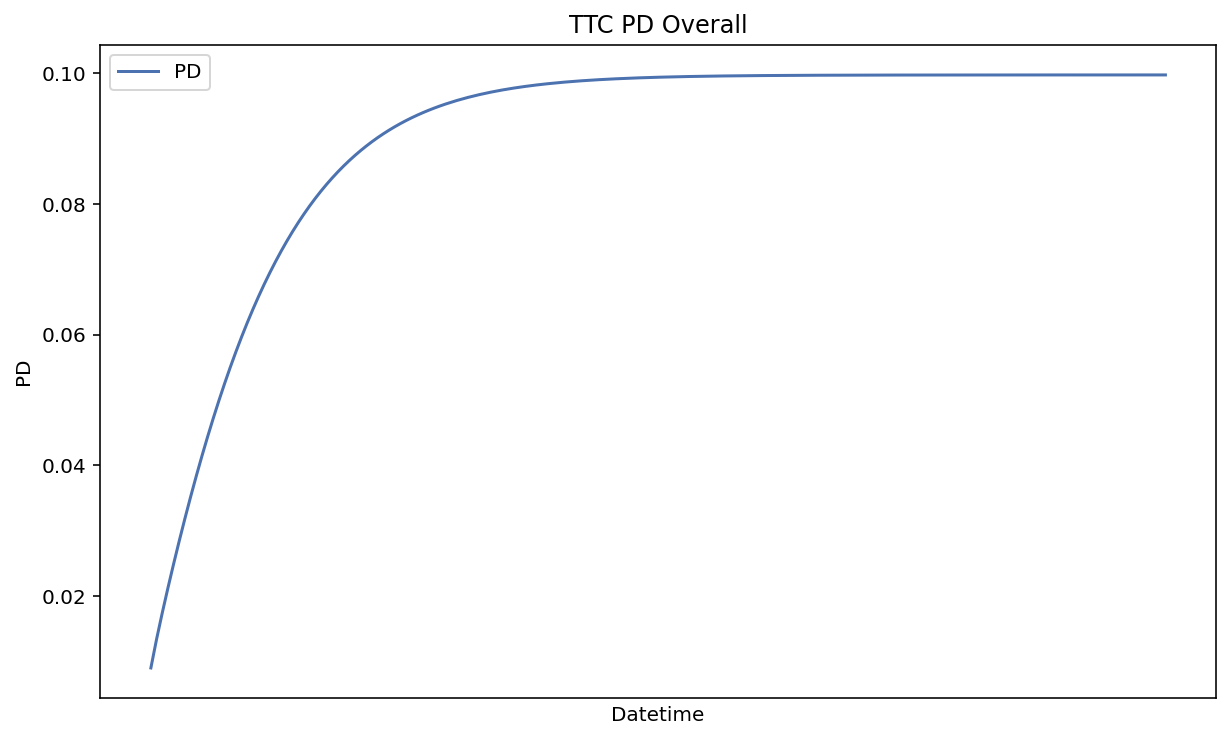

In [3]:
# Import dataset
# Average data
df = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/averageCalibrationCT.csv'
)

# Select one (CU) segment for example
df = df.query(
    "Segment == 'CU'"
).drop(
    ['Segment', 'N'],
    axis = 1
)

# Plot
plt.figure(figsize = (10, 6))
ax = sns.lineplot(
    data = df.melt(
        var_name = ['Date time'],
        value_name = 'PD'
    )
)
ax.set_title('TTC PD Overall')
ax.set(xlabel = 'Datetime', ylabel = 'PD')
ax.set_xticklabels([])
ax.set_xticks([])
plt.show()

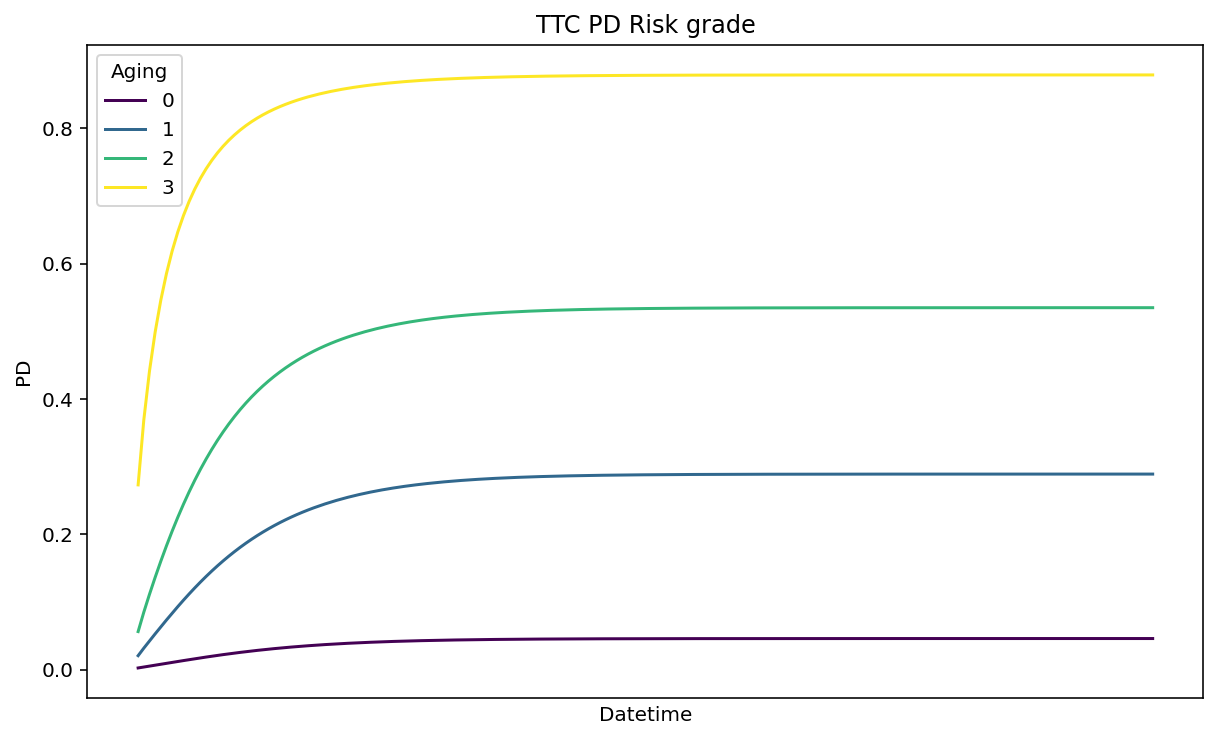

In [4]:
# Risk grade data
dfRisk = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/PDCalibrationCT.csv'
)

# Select one (CU) segment for example
dfRisk = dfRisk.query(
    "Segment == 'CU'"
).drop(
    ['Unnamed: 0', 'Segment', 'Aging'],
    axis = 1
) #The dataset is already weighted average cumulative PD

# Plot
plt.figure(figsize = (10, 6))
ax = sns.lineplot(
    x = 'times',
    y = 'PD',
    data = pd.melt(
        dfRisk.iloc[:, 1:].reset_index().rename(
            columns = {'index': 'Aging'}
        ),
        id_vars = ['Aging'],
        var_name = 'times',
        value_name = 'PD'
    ),
    hue = 'Aging',
    legend = 'full',
    palette = 'viridis',
    ci = None
)
ax.set_title('TTC PD Risk grade')
ax.set(xlabel = 'Datetime', ylabel = 'PD')
ax.set_xticklabels([])
ax.set_xticks([])
plt.show()

In [5]:
# Define plot function
def plotPD(data1, data2, title):
  fig = plt.figure(figsize = (10, 6))
  ax = fig.add_subplot(111)
  ax.plot(
      data1,
      c = 'royalblue',
      label = 'Overall calibration',
      linestyle = '--'
  )
  ax.plot(
      data2,
      c = 'forestgreen',
      label = 'Risk grade calibration'
  )
  ax.axvline(x = 12, c = 'firebrick', label = '12-Month')
  ax.set_title(f'{title}')
  ax.set(
      xlabel = f'PD Curve by overall: {data1[11]*100:.2f}%\nPD Curve by risk grade: {data2[11]*100:.2f}%',
      ylabel = 'PD'
  )
  ax.set_xticklabels([])
  ax.set_xticks([])
  ax.legend(
      frameon = True,
      facecolor = 'white'
  )
  return plt.show()

### Probability of default (PD)
Probability of default (PD) is a financial term describing the likelihood of a default over a particular time horizon. It provides an estimate of the likelihood that a borrower will be unable to meet its debt obligations.

The **through the cycle (TTC)** PD has been built based on observation time in **monthly basis** and cumulative throughout lifetime period in the cumulative basis. To derive marginal PD from cumulative PD can be referred formula below:

\begin{align}
        \text{Marginal PD}_{1m(t)} = \text{Cumulative PD}_{1m(t)} - \text{Cumulative PD}_{1m(t - 1)}
    \end{align}

Given the model was developed on 12-Month Observed Default Rate (ODR), the macro effect will be incorporated on Conditional PD by assumed to be the same basis. To convert 12-Month marginal PD to 12-Mointh conditional PD used formula below:

\begin{align}
        \text{Contional PD}_{1m(t)} = \frac{\text{Marginal PD}_{1m(t)}}{\text{1 - Cumulative PD}_{1m(t-1)}}
    \end{align}

Since the relationship with macroeconomics is 12-Month basis, it will be converted the 1-Month PD into corresponding 12-Month PD using PD compounding formula shown below:

\begin{align}
        \text{Contional PD}_{12m(t)} = 1 - (1 - \text{Contional PD}_{1m(t)})^{12}
    \end{align}

where;
- $t$ is specific time period.

In [6]:
# Define function PD
# Marginal PD
def marginalPD(cumPD):
  return cumPD.diff(1, axis = 1)

# Contional PD
def contionalPD(marPD, cumPD):
  return marPD / (1 - cumPD.shift(1, axis = 1))

# 12-Month PD
def PD12(conPD):
  return 1 - ((1 - conPD) ** 12) 

# 1-Month PD
def PD1(conPD):
  return 1 - ((1 - conPD) ** (1 / 12)) #Respect to 1-month

# Contional to Marginal PD
def con2marPD(conPD):
  return conPD * np.cumprod(1 - conPD, axis = 1).shift(1, axis = 1).fillna(1)

# Cumulative PD
def cumulativePD(marPD):
  return np.cumsum(marPD, axis = 1)

### Macro-overlay

Post obtaining the lifetime **through the cycle PD (TTC)** and the **forward-looking model (FWL)**, the next step is macro-overlay on the obtained TTC PD values using parameters obtained from FWL model. As the objective is to obtain the macro-overlay on TTC PD, the below functional form would be considered for model development.

\begin{align}
        \text{Conditional PD Adj}_{12m(t)} = logit^{-1}\left[logit(\text{Conditional PD}_{12m(t)}) + (\beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2} + ...) - logit(\text{TTC PD}_{12m(t)})\right]
    \end{align}

The adjusted 12-Month conditional PD will be converted back to 1-Month component in order to obtain conditional PD with macro-overlay by using the below formula:

\begin{align}
        \text{Contional PD Adj}_{1m(t)} = 1 - (1 - \text{Contional PD Adj}_{12m(t)})^{\frac{1}{12}}
    \end{align}

The adjusted 1-Month conditional PD will be converted back to 1-Month marginal PD adjusted by using the below formula:

\begin{align}
        \text{Mariginal PD Adj}_{1m(t)} = \text{Conditional PD Adj}_{1m(t)} * \prod_{t-1}^{t}(1 - \text{Conditional PD Adj}_{1m(t)})
    \end{align}

Finally, it can be converted the marginal PD adjusted back to cumulative PD with macro-overlay by using formula below:

\begin{align}
        \text{Cumulative PD Adj}_{1m(t)} = \sum_{t=1}^{t}\text{Marginal PD Adj}_{1m(t)}
    \end{align}

where;
- $t$ is specific time period.
- $logit$ is log-odds function defined as $ln(\frac{p}{1 - p})$

In [7]:
# Define function for liner calibration
def linearFWL(cumData, targetPD, adjustment = None):
  if len(cumData) > 1:
    '''
    To check row of risk grade.
    If the row more than 1, means risk grade level.
    If equal to 1, means average level.
    Then, it keeps the first period of PD
    '''
    cumData = cumData.iloc[:, 1:]
    firstPD = cumData.iloc[:, 0]
  else:
    firstPD = cumData.iloc[0, 0]
  marPD = marginalPD(cumData) #Marginal PD
  marPD.iloc[:, 0] = firstPD #Replace with first PD
  conPD = contionalPD(marPD, cumData) #Conditional PD
  conPD.iloc[:, 0] = firstPD #Replace with first PD
  conPD12 = PD12(conPD) #Respect to 12-month PD
  # Linear adjustment
  '''
  The adjustment is set target PD equal to 12-Month TTC PD.
  Since, the FWL Model is performed on 12-Month ODR.
  Assumed that 12-Month ODR basis is the same as conditional PD.
  '''
  conPDAdj = expit(
      logit(conPD12) + logit(targetPD) - logit(df.iloc[0, 11])
  )
  conPDAdj = PD1(conPDAdj) #Respect to 1-month
  marPDAdj = con2marPD(conPDAdj) #Post-Marginal PD
  if adjustment is not None:
    '''
    After adjustment, weighted average and overall TTC is not equal.
    Thus, the adjustment factors need to be optimized.
    The cost function is to minimize error between weighted average and overall TTC.
    '''
    cumPDAdj = cumulativePD(marPDAdj) * adjustment #Post-Cumulative PD
  else:
    cumPDAdj = cumulativePD(marPDAdj)
  return cumPDAdj

### Macro-overlay issue
It is observed that the macro-overlay, which is calculated on overall TTC curve is slightly different from overall TTC PD post calibration from risk grade level.

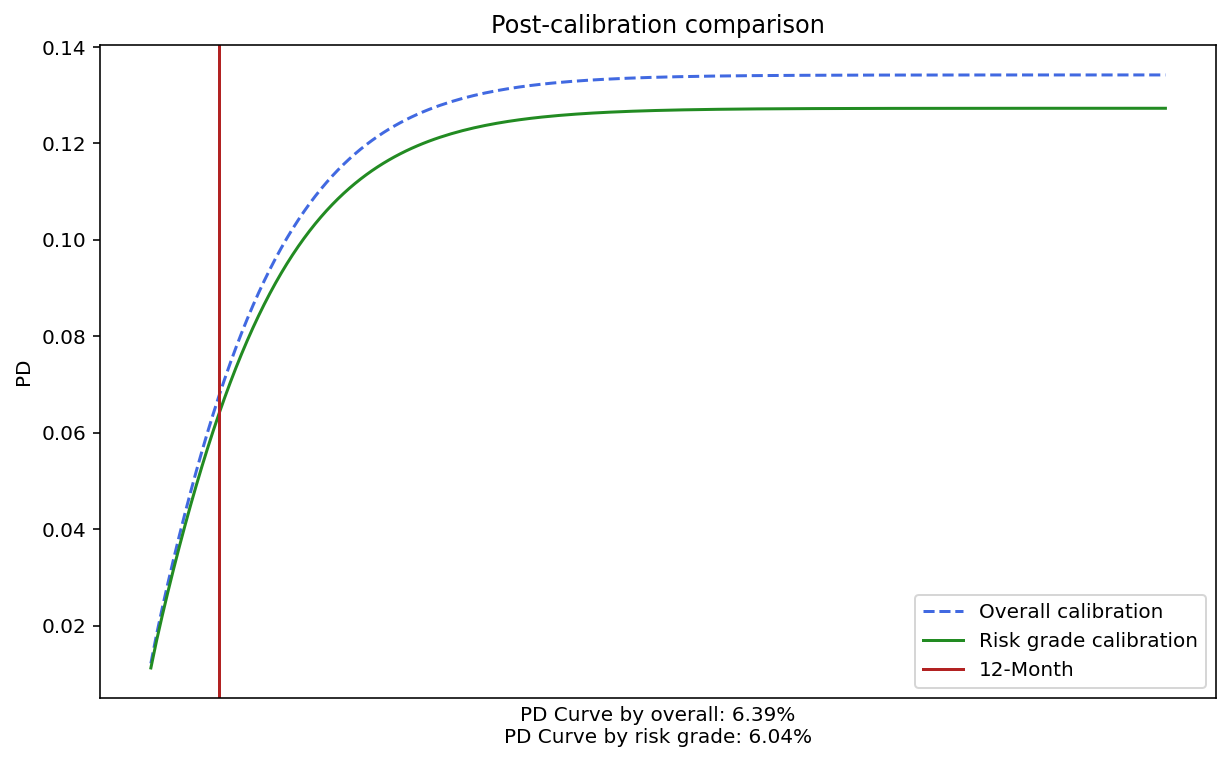

In [8]:
# Calibrate on average curve
targetFWL = 0.064 #Assume to be FWL PD from the model

# Calibrate on average curve
dfPost = linearFWL(df, targetFWL).values[0]

# Calibrate on risk grade curve
dfRiskPost = linearFWL(dfRisk, targetFWL)
dfRiskPost = np.average(
    dfRiskPost,
    weights = dfRisk['N'],
    axis = 0
) #Weighted average

# Plot
plotPD(dfPost, dfRiskPost, 'Post-calibration comparison')

### Macro-overlay adjstment
To minimize the noise effect, the adjustment factors are multiplied at cumulative level on each risk grade. Therefore, the sum of difference average of post calibration between overall and risk grade is minimised. Also, to avoid under estimation, an additional constraint is added that the difference between overall and risk grade PD is always positive. The following function is being used to find the adjustment values.

\begin{align}
        \text{Cumulative PD Adj}_{12m(t, i)} = \text{Cumulative PD}_{12m(t, i)} * \text{Adjustment factors}_{t}
    \end{align}

where;
- $t$ is specific time period.
- $i$ is specific risk grade.

In [9]:
# Define function for optimization liner calibration
def PDCalibration(x):
  overall = linearFWL(df, targetFWL).values[0]
  riskGrade = linearFWL(dfRisk, targetFWL, adjustment = x)
  riskGrade = np.average(
      riskGrade,
      weights = dfRisk['N'],
      axis = 0
  )
  # Different PD
  diff = overall - riskGrade
  error = np.abs(diff)
  return error

# Define minimize error
def findAdjustment(x):
  return PDCalibration(x)

In [10]:
# Initial guess
x0 = np.random.randn(df.shape[1])

In [11]:
# Finding adjustment factor
adjFactors = fsolve(findAdjustment, x0)

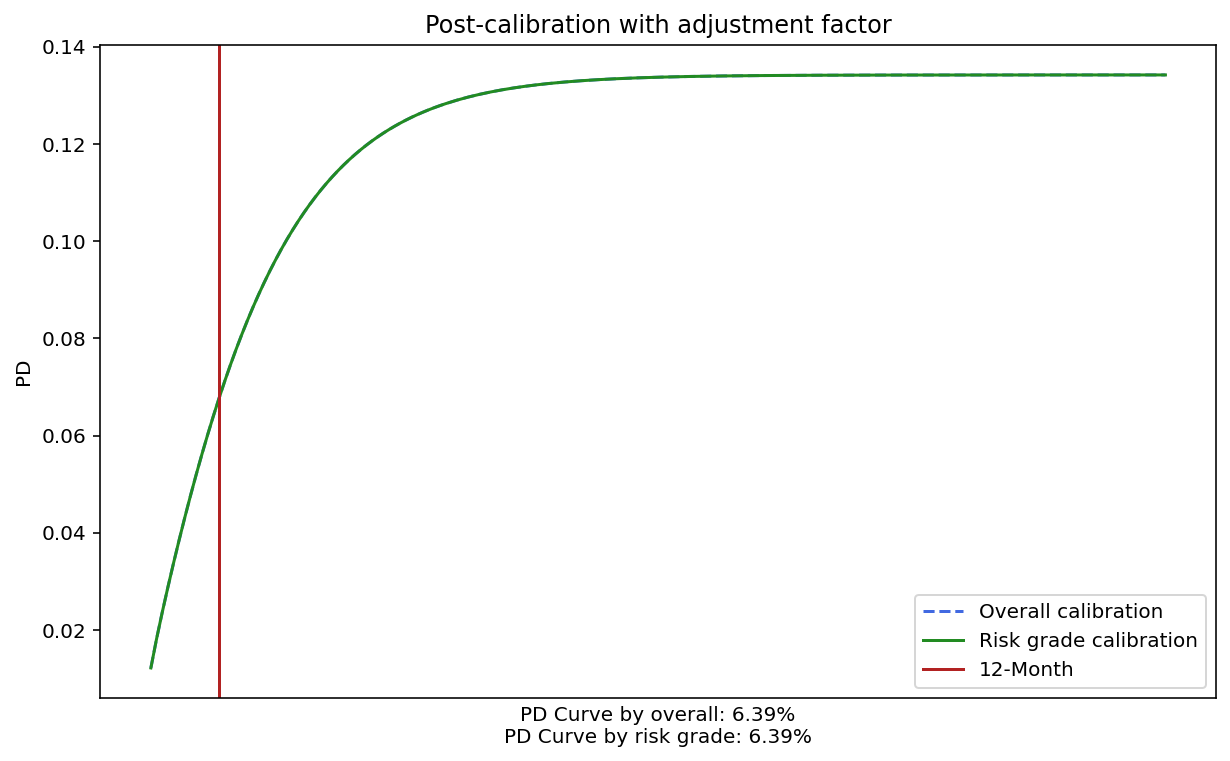

In [12]:
# Calibration with adjustment factor
dfRiskAdj = linearFWL(dfRisk, targetFWL, adjustment = adjFactors)
dfRiskAvg = np.average(
    dfRiskAdj,
    weights = dfRisk['N'],
    axis = 0
)

# Plot
plotPD(dfPost, dfRiskAvg, 'Post-calibration with adjustment factor')

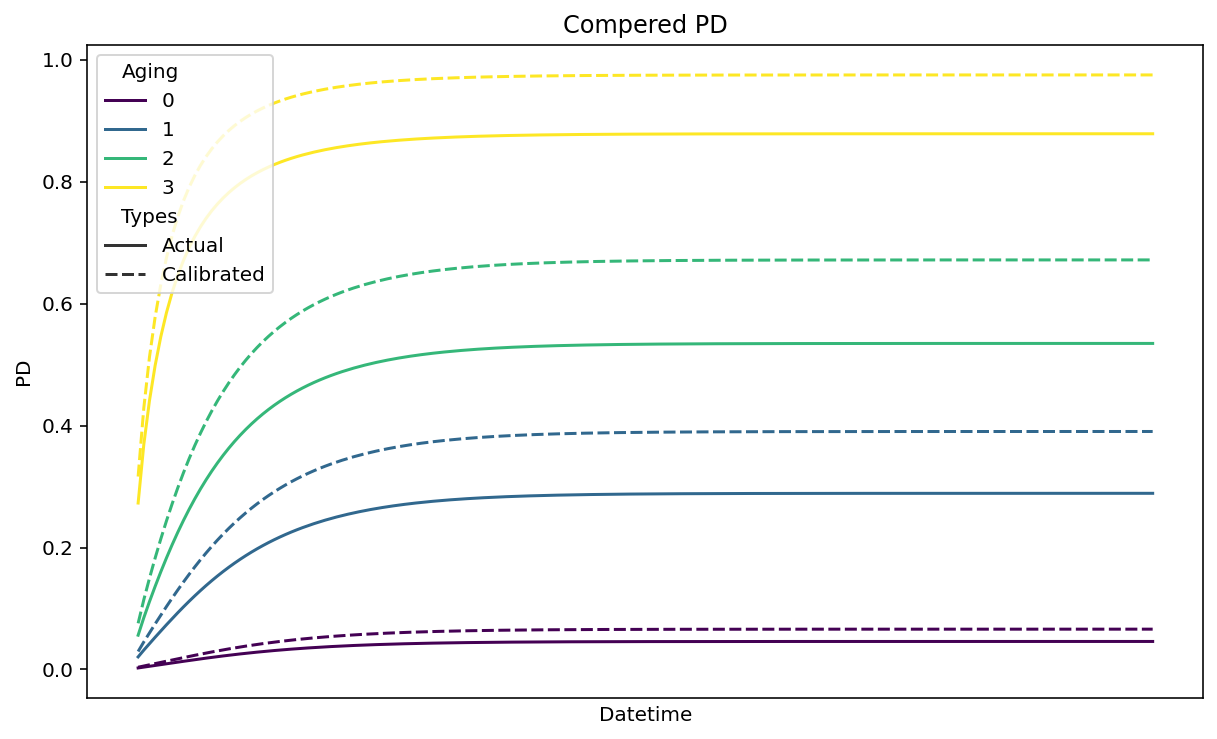

In [13]:
# Plot compare risk grade level
plt.figure(figsize = (10, 6))
ax = sns.lineplot(
    x = 'times',
    y = 'PD',
    data = pd.concat(
        [
         pd.melt(
             dfRisk.iloc[:, 1:].reset_index().rename(
                 columns = {'index': 'Aging'}
             ),
             id_vars = ['Aging'],
            var_name = 'times',
            value_name = 'PD'
         ).assign(Types = 'Actual'),
         pd.melt(
             dfRiskAdj.reset_index().rename(
                 columns = {'index': 'Aging'}
             ),
             id_vars = ['Aging'],
            var_name = 'times',
            value_name = 'PD'
         ).assign(Types = 'Calibrated'),
        ],
        axis = 0,
        ignore_index = True
    ),
    hue = 'Aging',
    style = 'Types',
    legend = 'full',
    palette = 'viridis',
    ci = None
)
ax.set_title('Compered PD')
ax.set(xlabel = 'Datetime', ylabel = 'PD')
ax.set_xticklabels([])
ax.set_xticks([])
plt.show()